In [1]:
pip install opencv-python idx2numpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 2.5 MB/s eta 0:00:0000:0100:020m
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=9f20b83da66bf01f95ed75faeda9d47511b5d59ea4972ab1e23965379c300974
  Stored in directory: /home/jovyan/.cache/pip/wheels/f7/48/00/ae031c97d62f39e1c3c4daa00426c09a65eb29ae5753a189ee
Successfully built idx2numpy
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from IPython.display import display
import idx2numpy
import gzip
import numpy as np

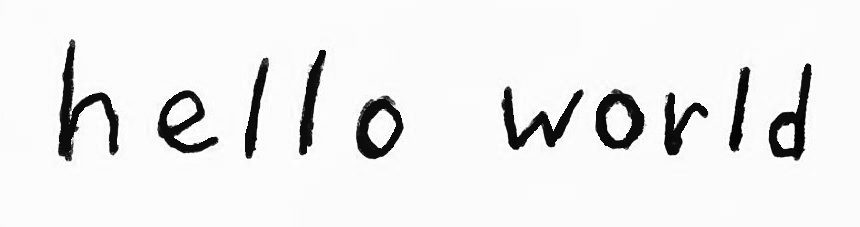

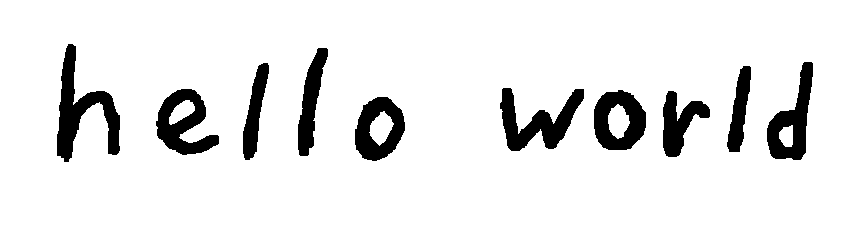

In [3]:
img = cv2.imread("text-hand.png")
display(Image.fromarray(img))

# Переводим картинку в ч/б (и так была ч/б)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Бинаризация изображения с помощью метода пороговой обработки
ret, img_thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)
# Эрозия на бинарном изображении
img_erode = cv2.erode(img_thresh, np.ones((3, 3), np.uint8), iterations=2)

display(Image.fromarray(img_erode))

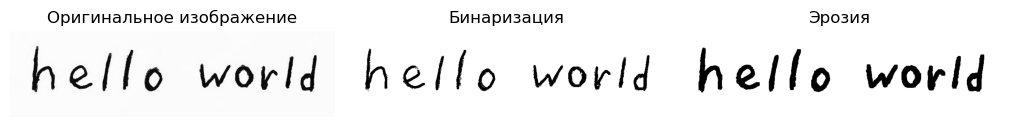

In [4]:
# Открываем изображение
img = cv2.imread("text-hand.png")

fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(10, 3))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_axis_off()
axs[0].set_title("Оригинальное изображение")

# Переводим картинку в ч/б (и так была ч/б)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Бинаризация изображения с помощью метода пороговой обработки
ret, img_thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

axs[1].imshow(cv2.cvtColor(img_thresh, cv2.COLOR_BGR2RGB))
axs[1].set_axis_off()
axs[1].set_title("Бинаризация")

# Эрозия на бинарном изображении
img_erode = cv2.erode(img_thresh, np.ones((3, 3), np.uint8), iterations=2)

axs[2].imshow(cv2.cvtColor(img_erode, cv2.COLOR_BGR2RGB))
axs[2].set_axis_off()
axs[2].set_title("Эрозия")

plt.show()

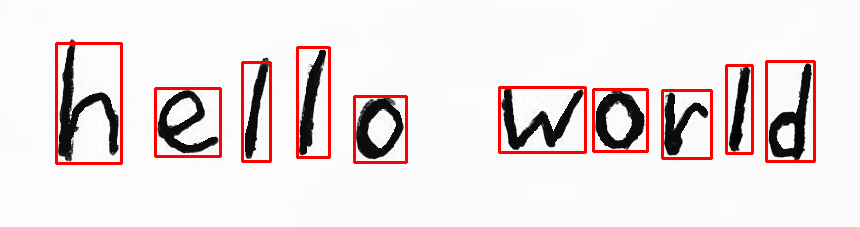

In [5]:
# Нахождение контуров
contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

output = img.copy()

# Рисуем прямоугольники вокруг контуров
for idx, contour in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    if hierarchy[0][idx][3] == 0:  # Если контур не имеет родительских контуров
        # Рисуем прямоугольник в виде бокса
        cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)

display(Image.fromarray(output))

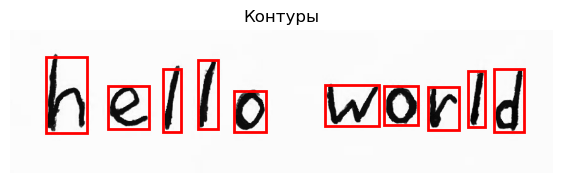

In [6]:
# Нахождение контуров
contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Для каждого контура рисуем его bounding box
for idx, contour in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    if hierarchy[0][idx][3] == 0:  # Если контур не имеет родительских контуров
        # Рисуем прямоугольник в виде бокса
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

ax.set_axis_off()
ax.set_title("Контуры")
plt.show()

In [7]:
def letters_extract(image_file: str, out_size=28):
    # Чтение изображения
    img = cv2.imread(image_file)

    # Преобразование изображения в градации серого
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Бинаризация изображения
    ret, thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)
    # Эрозия изображения для улучшения контуров
    img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1)

    # Получение контуров
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    output = img.copy()

    # Список для сохранения букв
    letters = []

    # Перебираем контуры
    for idx, contour in enumerate(contours):
        # Получение ограничивающего прямоугольника для контура
        (x, y, w, h) = cv2.boundingRect(contour)

        # Проверка, что контур не вложен в другой контур
        if hierarchy[0][idx][3] == 0:
            # Вырезаем букву
            letter_crop = gray[y:y + h, x:x + w]

            # Приведение буквы к квадрату
            size_max = max(w, h)
            letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)

            if w > h:
                # Увеличение изображения по вертикали
                y_pos = size_max // 2 - h // 2
                letter_square[y_pos:y_pos + h, 0:w] = letter_crop
            elif w < h:
                # Увеличение изображения по горизонтали
                x_pos = size_max // 2 - w // 2
                letter_square[0:h, x_pos:x_pos + w] = letter_crop
            else:
                letter_square = letter_crop

            # Изменение размера буквы и добавление в список
            letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))

    # Сортировка букв по координате X (чтобы располагать их слева направо)
    letters.sort(key=lambda x: x[0], reverse=False)

    return letters

letters=letters_extract('text-hand.png')
display(Image.fromarray(letters[0][2]))
display(Image.fromarray(letters[1][2]))
display(Image.fromarray(letters[2][2]))
display(Image.fromarray(letters[3][2]))
display(Image.fromarray(letters[4][2]))
display(Image.fromarray(letters[5][2]))

In [8]:
from tensorflow import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.constraints import max_norm
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold

2024-10-24 07:29:36.242554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 07:29:36.379249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 07:29:36.420040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 07:29:36.702309: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 07:29:38.219427: W tensorflow/compiler/tf2

In [9]:
# EMNIST (Extended MNIST)
def emnist_model():
    # Инициализация модели
    model = Sequential()

    # Первый сверточный слой с 32 фильтрами, размером ядра (3, 3), активация ReLU
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='valid', input_shape=(28, 28, 1), activation='relu'))

    # Второй сверточный слой с 64 фильтрами, активация ReLU
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))

    # Слой подвыборки (MaxPooling) с размером окна (2, 2)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Слой Dropout для предотвращения переобучения (25% нейронов отключаются случайным образом)
    model.add(Dropout(0.25))

    # Преобразование двумерных данных в одномерный вектор
    model.add(Flatten())

    # Полносвязный слой с 512 нейронами, активация ReLU
    model.add(Dense(512, activation='relu'))

    # Слой Dropout для предотвращения переобучения (50% нейронов отключаются случайным образом)
    model.add(Dropout(0.5))

    # Выходной полносвязный слой, количество нейронов соответствует числу классов (emnist_labels), активация softmax
    model.add(Dense(len(emnist_labels), activation='softmax'))

    # Компиляция модели с функцией потерь 'categorical_crossentropy', оптимизатором 'adadelta' и метрикой 'accuracy'
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    return model


In [20]:
# Путь к набору данных EMNIST
emnist_path = 'dataset/'

# Функция для исправления поворота и зеркального отображения
def correct_image_orientation(images):
    corrected_images = []
    for img in images:
        # Поворот изображения на 90 градусов против часовой стрелки
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        # Отзеркаливание по вертикали
        corrected_img = cv2.flip(rotated_img, 0)
        # Инверсия цветов (фон становится белым, а текст — чёрным)
        inverted_img = 255 - corrected_img
        # Бинаризация изображения
        ret, thresh_img = cv2.threshold(inverted_img, 50, 255, cv2.THRESH_BINARY)
        # Эрозия изображения для улучшения контуров
        erode_img = cv2.erode(thresh_img, np.ones((2, 2), np.uint8), iterations=1)
        corrected_images.append(erode_img)
    return np.array(corrected_images)

# Загрузка тренировочных изображений и меток с использованием idx2numpy
with gzip.open(emnist_path + 'emnist-byclass-train-images-idx3-ubyte.gz', 'rb') as f:
    X_train = idx2numpy.convert_from_file(f)
with gzip.open(emnist_path + 'emnist-byclass-train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = idx2numpy.convert_from_file(f)

# Загрузка тестовых изображений и меток
with gzip.open(emnist_path + 'emnist-byclass-test-images-idx3-ubyte.gz', 'rb') as f:
    X_test = idx2numpy.convert_from_file(f)
with gzip.open(emnist_path + 'emnist-byclass-test-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = idx2numpy.convert_from_file(f)

# Применение исправлений к тренировочным и тестовым изображениям
X_train = correct_image_orientation(X_train)
X_test = correct_image_orientation(X_test)

# Преобразование изображений в форму (количество, 28, 28, 1) для использования в модели
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

# Чтение файла и создание отображения индексов на символы
emnist_labels = {}
with open(emnist_path + 'emnist-byclass-mapping.txt', 'r') as f:
    for line in f:
        index, ascii_code = line.split()
        emnist_labels[int(index)] = chr(int(ascii_code))  # Преобразование ASCII-кода в символ

# Проверка размеров данных
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, len(emnist_labels))

# Уменьшение размера набора данных для ускорения обучения (в 5 раз)
# k = 5
k = 3
X_train = X_train[:X_train.shape[0] // k]
y_train = y_train[:y_train.shape[0] // k]
X_test = X_test[:X_test.shape[0] // k]
y_test = y_test[:y_test.shape[0] // k]

# Нормализация изображений к диапазону [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Преобразование меток в категориальный формат (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, len(emnist_labels))
y_test_cat = keras.utils.to_categorical(y_test, len(emnist_labels))

# Вывод данных после преобразований для проверки
print(f"Тренировочные данные: {X_train.shape}, Метки: {y_train_cat.shape}")
print(f"Тестовые данные: {X_test.shape}, Метки: {y_test_cat.shape}")

(697932, 28, 28, 1) (697932,) (116323, 28, 28, 1) (116323,) 62
Тренировочные данные: (232644, 28, 28, 1), Метки: (232644, 62)
Тестовые данные: (38774, 28, 28, 1), Метки: (38774, 62)


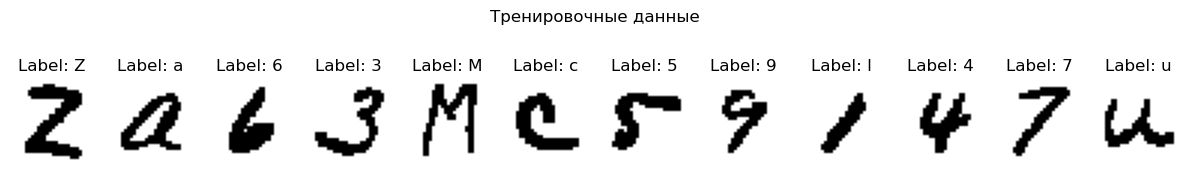

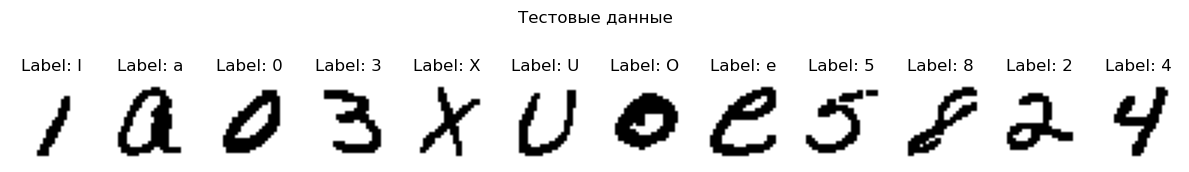

In [21]:
def plot_samples_with_ax(X_data, y_data, title, emnist_labels, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(12, 2))

    for i in range(num_samples):
        # Отображаем изображение на соответствующем ax
        axs[i].imshow(X_data[i].reshape(28, 28), cmap='gray')
        # Устанавливаем заголовок для каждого изображения
        axs[i].set_title(f"Label: {emnist_labels[np.argmax(y_data[i])]}")
        # Отключаем оси
        axs[i].axis('off')

    # Устанавливаем заголовок для всей фигуры
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

# Отображаем 12 тренировочных изображений
plot_samples_with_ax(X_train, y_train_cat, "Тренировочные данные", emnist_labels, num_samples=12)

# Отображаем 12 тестовых изображений
plot_samples_with_ax(X_test, y_test_cat, "Тестовые данные", emnist_labels, num_samples=12)

In [22]:
# Определение модели
model = emnist_model()

# Добавляем чекпоинты для сохранения лучших весов
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Обучение модели
history = model.fit(
    X_train, y_train_cat,                 # Тренировочные данные и метки
    batch_size=128,                       # Размер батча
    epochs=50,                            # Количество эпох
    validation_data=(X_test, y_test_cat), # Валидационные данные
    callbacks=[checkpoint],               # Используем чекпоинты
    verbose=1                             # Отображение процесса обучения
)

# Загрузка лучших весов после обучения
model.load_weights('best_model.keras')

# Оценка модели на тестовых данных
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=2)
print(f'Точность на тестовых данных: {test_acc * 100:.2f}%')

/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1729755270.075720     127 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729755270.394872     127 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729755270.394936     127 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729755270.398522     127 cuda_executor.cc:1001] 

Epoch 1/50


I0000 00:00:1729755273.711857     939 service.cc:146] XLA service 0x7f7f28005310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729755273.711891     939 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-24 07:34:33.759269: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-24 07:34:33.951723: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-24 07:34:35.435746: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1103', 76 bytes spill stores, 80 bytes spill loads

2024-10-24 07:34:35.625216: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in functi

  59/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0160 - loss: 4.1347

I0000 00:00:1729755277.946858     939 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1818/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0570 - loss: 3.9822

2024-10-24 07:34:48.936829: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_72', 44 bytes spill stores, 44 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.18667, saving model to best_model.keras
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.0570 - loss: 3.9821 - val_accuracy: 0.1867 - val_loss: 3.6247
Epoch 2/50
1813/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1097 - loss: 3.6586
Epoch 2: val_accuracy improved from 0.18667 to 0.33133, saving model to best_model.keras
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1097 - loss: 3.6585 - val_accuracy: 0.3313 - val_loss: 3.4199
Epoch 3/50
1807/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1860 - loss: 3.4742
Epoch 3: val_accuracy improved from 0.33133 to 0.39550, saving model to best_model.keras
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1861 - loss: 3.4739 - val_accuracy: 0.3955 - val_loss: 3.1526
Epoch 4/50
1806/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2725 - loss: 3.2295
Epoch 4: val_accuracy improved from 0.39550 to 0.43184, saving model to best_model.keras
1818/1818 ━━━━━━━━━━━━━━

In [16]:
# Количество фолдов для кросс-валидации
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)

# Списки для сохранения результатов
fold_accuracies = []

# Обучение модели с использованием кросс-валидации
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train_cat)):
    print(f"Обучение на фолде {fold_idx + 1}/{n_folds}")
    
    # Создаем модель для каждого фолда
    model = emnist_model()
    
    # Получаем данные для текущего фолда
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train_cat[train_idx], y_train_cat[val_idx]

    # Обучение модели на текущем фолде
    history = model.fit(
        X_train_fold, y_train_fold,                # Тренировочные данные для текущего фолда
        batch_size=128,                            # Размер батча
        epochs=10,                                 # Количество эпох
        validation_data=(X_val_fold, y_val_fold),  # Валидационные данные для текущего фолда
        verbose=1                                  # Отображение процесса обучения
    )

    # Оценка модели на валидационных данных текущего фолда
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(val_acc)
    print(f"Точность на фолде {fold_idx + 1}: {val_acc * 100:.2f}%")

# Средняя точность по всем фолдам
mean_accuracy = np.mean(fold_accuracies)
print(f'Средняя точность по {n_folds} фолдам: {mean_accuracy * 100:.2f}%')

Обучение на фолде 1/5
Epoch 1/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0459 - loss: 4.0074

2024-10-24 07:22:48.256266: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_72', 44 bytes spill stores, 44 bytes spill loads



1455/1455 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.0459 - loss: 4.0073 - val_accuracy: 0.1100 - val_loss: 3.6906
Epoch 2/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0764 - loss: 3.7311 - val_accuracy: 0.2165 - val_loss: 3.5823
Epoch 3/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1014 - loss: 3.6486 - val_accuracy: 0.2869 - val_loss: 3.4833
Epoch 4/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ -75s -51478us/step - accuracy: 0.1415 - loss: 3.5603 - val_accuracy: 0.3538 - val_loss: 3.3541
Epoch 5/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - accuracy: 0.1959 - loss: 3.4331 - val_accuracy: 0.3887 - val_loss: 3.1900
Epoch 6/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2491 - loss: 3.2885 - val_accuracy: 0.4191 - val_loss: 2.9913
Epoch 7/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3009 - loss: 3.1072 - val_accuracy: 0.4392 - val_loss: 2.7793
Epoch 8/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3392 - loss: 2.9292 - v

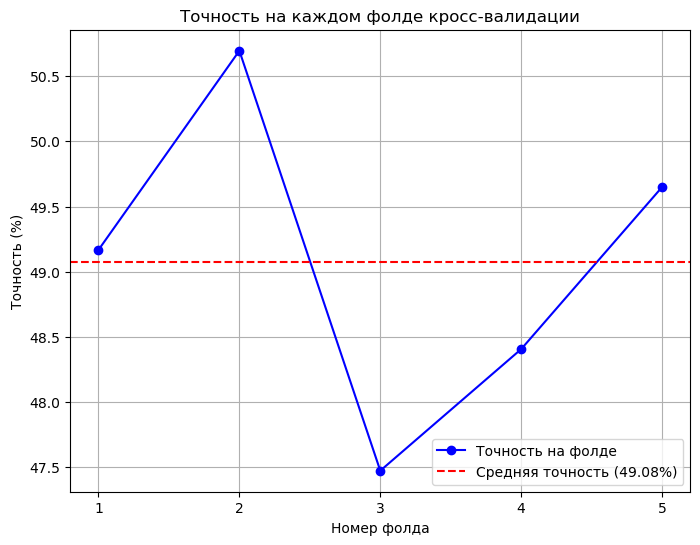

In [17]:
# Построение графика точности на каждом фолде
plt.figure(figsize=(8, 6))
folds = np.arange(1, len(fold_accuracies) + 1)

# Вывод точности для каждого фолда
plt.plot(folds, np.array(fold_accuracies) * 100, marker='o', linestyle='-', color='b', label='Точность на фолде')

# Вывод средней точности
plt.axhline(y=np.mean(fold_accuracies) * 100, color='r', linestyle='--', label=f'Средняя точность ({np.mean(fold_accuracies) * 100:.2f}%)')

# Настройка подписей
plt.title('Точность на каждом фолде кросс-валидации')
plt.xlabel('Номер фолда')
plt.ylabel('Точность (%)')
plt.xticks(folds)
plt.legend(loc='lower right')
plt.grid(True)

# Отображение графика
plt.show()

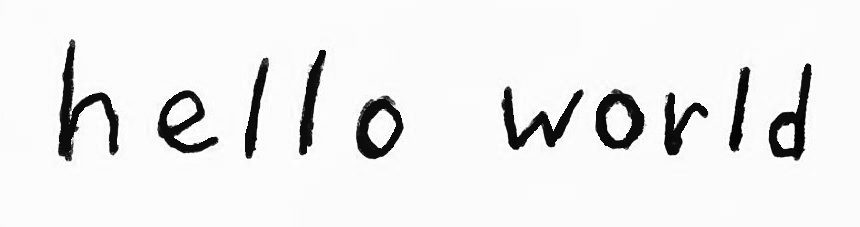

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Распознанный текст: h2110W0r1d


In [23]:
def recognize_text(image_file):
    # Извлекаем буквы с изображения
    letters = letters_extract(image_file)

    recognized_text = []

    # Пройдем по каждому фрагменту с буквой
    for _, _, letter in letters:
        # Преобразуем букву в формат, который принимает модель
        letter = letter.reshape(1, 28, 28, 1).astype('float32') / 255.0

        # Предсказываем класс с помощью обученной модели
        prediction = model.predict(letter)
        
        # Определяем индекс класса с наибольшей вероятностью
        predicted_label_index = np.argmax(prediction)

        # Получаем символ, используя наш словарь emnist_labels
        recognized_char = emnist_labels[predicted_label_index]
        recognized_text.append(recognized_char)

    # Соединяем буквы в строку и возвращаем результат
    return ''.join(recognized_text)

display(Image.fromarray(cv2.imread("text-hand.png")))
result_text = recognize_text("text-hand.png")
print(f"Распознанный текст: {result_text}")